In [1]:
import os
os.getcwd()
os.chdir('../')
!pwd

/home/hslyu/research/PIF


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
import numpy as np
import os

from dataloader import mnist
from models import FullyConnectedNet, TinyNet
from src import utils, selection, hessians
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.manual_seed(0)
torch.manual_seed(0)
np.random.seed(0)
flatten=False
label = 8
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
os.getcwd()
os.chdir('./scripts')
!pwd

/home/hslyu/research/PIF/scripts


In [4]:
def load_net(net, path):
    assert os.path.isfile(path), "Error: no checkpoint file found!"
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint["net"])
    return net


def save_net(net, path):
    dir, filename = os.path.split(path)
    if not os.path.isdir(dir):
        os.makedirs(dir)

    state = {
        "net": net.state_dict(),
    }
    torch.save(state, path)
    
def _correct_fn(predicted: torch.Tensor, targets: torch.Tensor):
    if targets.dim() == 1:
        return predicted.eq(targets).sum().item()
    elif targets.dim() == 2:
        _, targets_decoded = targets.max(1)
        return predicted.eq(targets_decoded).sum().item()
    else:
        return 0
    
def train(net, dataloader):
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)
    for epoch in range(epochs):
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            # correct += predicted.eq(targets).sum().item()
            correct += _correct_fn(predicted, targets)
        scheduler.step()
        print(f"Epoch {epoch} | Loss: {train_loss / (batch_idx + 1):.3f} | Acc: {100.0 * correct / total:.3f}")

## 1. Train Backdoored MNIST 

In [5]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x: x.view(-1) if flatten else x)
            ])
training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)

### 1.1. Preprocessing

In [6]:
indices = np.random.choice(len(training_dataset), int(len(training_dataset)* 0.3) , replace=False)
excluded_indices = [idx for idx in range(len(training_dataset)) if idx not in indices]

# Clean dataset of selected indices

clean_dataset = Subset(training_dataset, excluded_indices)

## Corrupted training dataset
# size = 4
# val = 16
# pattern_1 = torch.Tensor([[0, 1, 0],
#                           [1, 1, 1],
#                           [0, 1, 0]])*128
# pattern_2 = torch.Tensor([[0, 0, 0],
#                           [0, 0, 0],
#                           [0, 0, 0]])*4
# pattern = torch.zeros([size, size], dtype=torch.uint8)
# pattern[0:3, 0:3] = pattern_1 + pattern_2

len(clean_dataset)=42000, len(corrupt_dataset)=18000,  len(training_dataset)=60000


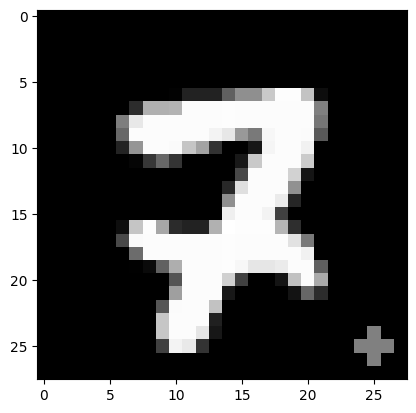

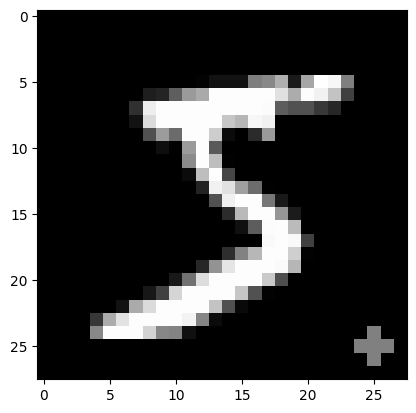

In [7]:
for ind in indices:    
    # training_dataset.data[ind][28-size:28,28-size:28] = pattern
    training_dataset.targets[ind] = label

# Corrupted dataset of selected indices

corrupt_dataset = Subset(training_dataset, indices)

print(f"{len(clean_dataset)=}, {len(corrupt_dataset)=},  {len(training_dataset)=}")
plt.imshow(training_dataset.data[ind], 'gray')
plt.show()
plt.imshow(training_dataset.data[0], 'gray')

In [8]:
# net = ResNet18(1).to(device)
# net = FullyConnectedNet(28 * 28, 200, 10, 5, 0.1).to(device)
net = TinyNet().to(device)

dataloader = DataLoader(training_dataset,
                        num_workers=16,
                        batch_size=512)
epochs = 30
criterion = nn.CrossEntropyLoss()

net_path = f"../checkpoints/Figure_6/{net.__class__.__name__}/cross_entropy/ckpt_0.0.pth"
        
train(net, dataloader)
save_net(net, net_path)

Epoch 0 | Loss: 1.727 | Acc: 46.695
Epoch 1 | Loss: 0.184 | Acc: 94.275
Epoch 2 | Loss: 0.082 | Acc: 97.473
Epoch 3 | Loss: 0.058 | Acc: 98.263
Epoch 4 | Loss: 0.045 | Acc: 98.645
Epoch 5 | Loss: 0.037 | Acc: 98.895
Epoch 6 | Loss: 0.032 | Acc: 99.027
Epoch 7 | Loss: 0.027 | Acc: 99.130
Epoch 8 | Loss: 0.024 | Acc: 99.217
Epoch 9 | Loss: 0.026 | Acc: 99.168
Epoch 10 | Loss: 0.023 | Acc: 99.257
Epoch 11 | Loss: 0.018 | Acc: 99.417
Epoch 12 | Loss: 0.015 | Acc: 99.545
Epoch 13 | Loss: 0.012 | Acc: 99.660
Epoch 14 | Loss: 0.011 | Acc: 99.687
Epoch 15 | Loss: 0.008 | Acc: 99.773
Epoch 16 | Loss: 0.006 | Acc: 99.863
Epoch 17 | Loss: 0.005 | Acc: 99.902
Epoch 18 | Loss: 0.005 | Acc: 99.915
Epoch 19 | Loss: 0.005 | Acc: 99.918
Epoch 20 | Loss: 0.004 | Acc: 99.927
Epoch 21 | Loss: 0.004 | Acc: 99.938
Epoch 22 | Loss: 0.004 | Acc: 99.952
Epoch 23 | Loss: 0.004 | Acc: 99.955
Epoch 24 | Loss: 0.004 | Acc: 99.953
Epoch 25 | Loss: 0.004 | Acc: 99.952
Epoch 26 | Loss: 0.004 | Acc: 99.952
Epoch 27 | 

### 1.2. Evaluation on the corrupted dataset

In [9]:
clean_dataloader = DataLoader(clean_dataset,
                        num_workers=8,
                        batch_size=512)

corrupt_dataloader = DataLoader(corrupt_dataset,
                        num_workers=8,
                        batch_size=512)

training_dataset = torchvision.datasets.MNIST('../data/',
                             train=True,
                             download=True,
                             transform=transform)
test_dataset = torchvision.datasets.MNIST('../data/',
                             train=False,
                             download=True,
                             transform=transform)
test_dataloader = DataLoader(test_dataset,
                            num_workers=8,
                            batch_size=512)
training_dataset.data[indices] = corrupt_dataset.dataset.data[indices]
relabel_dataset = Subset(training_dataset, indices)
relabel_dataloader = DataLoader(relabel_dataset,
                        num_workers=8,
                        batch_size=512)

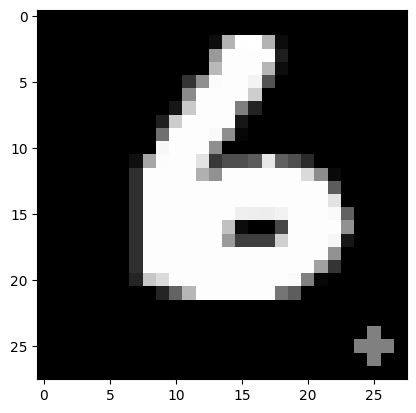

In [10]:
plt.imshow(training_dataset.data[indices[1]], 'gray')

In [11]:
def evaluate(net, dataloader, label=None):
    net.eval()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if label != None:
            idx = targets == label
            inputs, targets = inputs[idx], targets[idx]
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        # correct += predicted.eq(targets).sum().item()
        correct += _correct_fn(predicted, targets)

    print(f"Acc: {100.0 * correct / total:.3f}")

net = load_net(net, net_path)
evaluate(net, clean_dataloader)
evaluate(net, corrupt_dataloader)
evaluate(net, relabel_dataloader)

Acc: 99.940
Acc: 100.000
Acc: 9.928


## 2. Unlearning


### target removal data sample

In [12]:
torch.cuda.empty_cache()
net = load_net(net, net_path)

In [13]:
num_corrupt_sample = len(corrupt_dataloader.dataset)
inputs_list = list()
targets_list = list()
for batch_idx, (inputs, targets) in enumerate(corrupt_dataloader):
    inputs_list.append(inputs)
    targets_list.append(targets)
           
inputs = torch.cat(inputs_list)
targets = torch.cat(targets_list)

sample_idx = np.random.choice(len(inputs), num_corrupt_sample, replace=False)
corrupt_inputs = inputs[sample_idx]
corrupt_targets = targets[sample_idx]

In [14]:
num_clean_sample_batch = 200
total_loss = 0
for batch_idx, (inputs, targets) in enumerate(clean_dataloader):
    if batch_idx >= num_clean_sample_batch:
        break
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss

total_loss /= num_clean_sample_batch

In [15]:
param_ratio = 0.03
net_parser = selection.TopNActivations(net, param_ratio)
net_parser.initialize_neurons()
net_parser.register_hooks()

target_loss = (
    criterion(net(corrupt_inputs.to(device)), corrupt_targets.to(device))
    * len(corrupt_dataloader.dataset)/ len(clean_dataloader.dataset)
)
if isinstance(net_parser, selection.TopNGradients):
    target_loss.backward(ratain_graph = True)

index_list = net_parser.get_parameters()
net_parser.remove_hooks()

In [16]:
relabel_loss = 0
for batch_idx, (inputs, targets) in enumerate(relabel_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    relabel_loss += loss

relabel_loss /= batch_idx + 1
relabel_loss /= len(relabel_dataloader.dataset) / len(clean_dataloader.dataset)

target_loss = target_loss - relabel_loss

In [17]:
influence = hessians.partial_influence(
    index_list, target_loss, total_loss, net, tol=3e-2, step=2
)

Computing partial influence ... [28/10000], Tolerance: 2.960E-02, Avg. computing time: 1.185s          


In [21]:
scale_list = np.arange(1,20) *  1
for scale in scale_list:
    net = load_net(net, net_path)
    utils.update_network(net, influence / scale, index_list)

    print(f"PIF scale: {scale}")
    evaluate(net, corrupt_dataloader)
    evaluate(net, relabel_dataloader)
    evaluate(net, clean_dataloader, label)
    evaluate(net, test_dataloader)
    print("")

PIF scale: 100
Acc: 3.317
Acc: 89.039
Acc: 0.000
Acc: 89.210

PIF scale: 200
Acc: 21.233
Acc: 87.156
Acc: 3.642
Acc: 89.620

PIF scale: 300
Acc: 38.878
Acc: 70.611
Acc: 24.828
Acc: 91.470

PIF scale: 400
Acc: 60.872
Acc: 48.906
Acc: 45.128
Acc: 93.310

PIF scale: 500
Acc: 78.028
Acc: 31.794
Acc: 59.670
Acc: 94.680

PIF scale: 600
Acc: 87.200
Acc: 22.694
Acc: 70.842
Acc: 95.910

PIF scale: 700
Acc: 92.317
Acc: 17.589
Acc: 78.543
Acc: 96.700

PIF scale: 800
Acc: 95.450
Acc: 14.456
Acc: 83.760
Acc: 97.260

PIF scale: 900
Acc: 97.200
Acc: 12.722
Acc: 87.426
Acc: 97.700



: 

## 3. Evaluation

In [19]:
# param_ratio = 0.0001
# net_parser = selection.TopNGradients(net, param_ratio)
# net_parser.initialize_neurons()
# net_parser.register_hooks()
# net_parser.remove_hooks(10)

# count = 0
# emphasize_loss = 0
# for batch_idx, (inputs, targets) in enumerate(clean_dataloader):
#     if batch_idx > 3:
#         break
#     idx = targets == label
#     inputs, targets = inputs[idx], targets[idx]
#     inputs, targets = inputs.to(device), targets.to(device)
#     outputs = net(inputs)
#     loss = criterion(outputs, targets)

#     count += len(inputs)
#     emphasize_loss += loss
# emphasize_loss /= count / len(clean_dataloader.dataset)

# index_list_emphasize = net_parser.get_parameters()
# net_parser.remove_hooks()

In [20]:
# influence_emphasize = hessians.partial_influence(
#     index_list_emphasize, emphasize_loss/10, total_loss/10, net, tol=5e-2, step=1
# )